# AI-Enhanced Robo Advisor: LSTM for Indian Stock Price Prediction

## MTech Project - Financial Time Series Analysis (2015-2025)

This notebook mirrors the existing Autoformer pipeline but replaces the model with an LSTM. It trains a separate model per stock (Nifty 50 subset), evaluates, and visualizes results.

Table of Contents
1. Environment Setup & Imports
2. Data Download & Preparation
3. Data Cleaning & Preprocessing
4. Feature Engineering
5. Stock-Specific Splits & Datasets
6. LSTM Model Development
7. Model Training (Per-Stock)
8. Evaluation & Visualizations
9. Results Summary


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from typing import List, Dict, Tuple
import logging
import time
import os
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Create directories if they don't exist
for dir_name in ['data', 'models', 'results', 'logs']:
    os.makedirs(dir_name, exist_ok=True)

# Configuration
CONFIG = {
    # Stock Selection
    'tickers': [
        'RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS',
        'HINDUNILVR.NS', 'ITC.NS', 'KOTAKBANK.NS', 'LT.NS', 'BHARTIARTL.NS'
    ],
    'start_date': '2015-01-01',
    'end_date': '2025-01-01',
    'target_col': 'Close',

    # Stock-Specific Training
    'stock_specific_training': True,
    'train_years': 7,
    'val_years': 1.5,
    'test_years': 1.5,

    # Model Architecture
    'input_dim': None,  # Will be set based on features
    'hidden_dim': 256,  # Increased from 128
    'num_layers': 2,
    'dropout_rate': 0.2,
    'bidirectional': True,
    'attention': True,

    # Training Parameters
    'sequence_length': 180,  # Increased from 120
    'forecast_horizon': 5,
    'batch_size': 128,      # Increased from 64
    'epochs': 100,          # Increased from 60
    'learning_rate': 1e-4,  # Decreased from 5e-4
    'weight_decay': 1e-5,
    'patience': 20,         # Increased from 15
    
    # Learning Rate Schedule
    'lr_scheduler': 'cosine',  # Options: 'cosine', 'reduce_on_plateau'
    'warmup_epochs': 5,
    'min_lr': 1e-6,
    
    # Loss Function Weights
    'mse_weight': 0.6,
    'directional_weight': 0.25,
    'smoothness_weight': 0.15,

    # Paths
    'data_dir': 'data',
    'model_dir': 'models',
    'results_dir': 'results',
    'logs_dir': 'logs',

    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Print configuration
logger.info("Configuration:")
for key, value in CONFIG.items():
    logger.info(f"{key}: {value}")

2025-10-25 00:37:49,233 - INFO - Configuration:
2025-10-25 00:37:49,233 - INFO - tickers: ['RELIANCE.NS']
2025-10-25 00:37:49,233 - INFO - start_date: 2015-01-01
2025-10-25 00:37:49,234 - INFO - end_date: 2025-01-01
2025-10-25 00:37:49,234 - INFO - target_col: Close
2025-10-25 00:37:49,235 - INFO - stock_specific_training: True
2025-10-25 00:37:49,235 - INFO - train_years: 7
2025-10-25 00:37:49,236 - INFO - val_years: 1.5
2025-10-25 00:37:49,236 - INFO - test_years: 1.5
2025-10-25 00:37:49,237 - INFO - input_dim: None
2025-10-25 00:37:49,238 - INFO - hidden_dim: 256
2025-10-25 00:37:49,238 - INFO - num_layers: 2
2025-10-25 00:37:49,238 - INFO - dropout_rate: 0.2
2025-10-25 00:37:49,239 - INFO - bidirectional: True
2025-10-25 00:37:49,239 - INFO - attention: True
2025-10-25 00:37:49,240 - INFO - sequence_length: 180
2025-10-25 00:37:49,240 - INFO - forecast_horizon: 5
2025-10-25 00:37:49,240 - INFO - batch_size: 128
2025-10-25 00:37:49,241 - INFO - epochs: 1
2025-10-25 00:37:49,241 - IN

In [22]:
# Data Download & Preparation
def download_stock_data(ticker: str, start_date: str, end_date: str, max_retries: int = 3) -> pd.DataFrame:
    for attempt in range(max_retries):
        try:
            logger.info(f"Downloading data for {ticker} from {start_date} to {end_date} (Attempt {attempt + 1})")
            data = yf.Ticker(ticker).history(start=start_date, end=end_date)
            
            if data.empty:
                logger.warning(f"No data retrieved for {ticker}")
                return pd.DataFrame()
                
            data.reset_index(inplace=True)
            data['Ticker'] = ticker
            data['Date'] = pd.to_datetime(data['Date'])
            
            # Calculate basic features
            data['Returns'] = data['Close'].pct_change()
            data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
            data['Volatility'] = data['Returns'].rolling(window=20).std()
            
            # Ensure all required columns exist
            if 'Adj Close' not in data.columns:
                data['Adj Close'] = data['Close']
                
            # Basic data validation
            required_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
            if any(col not in data.columns for col in required_cols):
                missing = [col for col in required_cols if col not in data.columns]
                logger.error(f"Missing required columns for {ticker}: {missing}")
                return pd.DataFrame()
                
            # Check for sufficient data points
            if len(data) < 50:  # Minimum required data points
                logger.warning(f"Insufficient data points for {ticker}: {len(data)}")
                return pd.DataFrame()
                
            logger.info(f"Successfully downloaded {len(data)} records for {ticker}")
            return data
            
        except Exception as e:
            logger.error(f"Error downloading {ticker} (Attempt {attempt + 1}): {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
            else:
                logger.error(f"Failed to download {ticker} after {max_retries} attempts")
                return pd.DataFrame()

def download_all_stocks(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    frames = []
    failed_tickers = []
    
    for t in tqdm(tickers, desc="Downloading stock data", disable=None):
        df = download_stock_data(t, start_date, end_date)
        if not df.empty:
            frames.append(df)
        else:
            failed_tickers.append(t)
        time.sleep(0.1)  # Rate limiting
        
    if failed_tickers:
        logger.warning(f"Failed to download data for: {', '.join(failed_tickers)}")
        
    if not frames:
        logger.error("No data downloaded for any ticker")
        return pd.DataFrame()
        
    result = pd.concat(frames, ignore_index=True)
    logger.info(f"Downloaded data shape: {result.shape}")
    return result

print("🚀 Starting data download...")
raw_data = download_all_stocks(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'])

if not raw_data.empty:
    print(f"✅ Data downloaded successfully")
    print(f"Shape: {raw_data.shape}")
    print("\nSample of downloaded data:")
    print(raw_data.head())
    print("\nData info:")
    print(raw_data.info())
    
    # Save raw data
    raw_data.to_csv(f"{CONFIG['data_dir']}/raw_stock_data.csv", index=False)
    print(f"\nData saved to {CONFIG['data_dir']}/raw_stock_data.csv")
else:
    print("❌ Data download failed")

🚀 Starting data download...


2025-10-25 00:37:49,273 - INFO - Downloading data for RELIANCE.NS from 2015-01-01 to 2025-01-01 (Attempt 1)
2025-10-25 00:37:49,297 - INFO - Successfully downloaded 2467 records for RELIANCE.NS
2025-10-25 00:37:49,398 - INFO - Downloaded data shape: (2467, 13)


✅ Data downloaded successfully
Shape: (2467, 13)

Sample of downloaded data:
                       Date        Open        High         Low       Close  \
0 2015-01-01 00:00:00+05:30  189.657431  190.877155  189.090351  189.999802   
1 2015-01-02 00:00:00+05:30  190.042601  191.743813  189.229456  189.496933   
2 2015-01-05 00:00:00+05:30  189.379224  190.641759  187.046752  187.421234   
3 2015-01-06 00:00:00+05:30  186.169449  186.811408  178.037899  178.915253   
4 2015-01-07 00:00:00+05:30  179.129243  183.772776  179.107845  182.809830   

     Volume  Dividends  Stock Splits       Ticker   Returns  Log_Returns  \
0   2963643        0.0           0.0  RELIANCE.NS       NaN          NaN   
1   7331366        0.0           0.0  RELIANCE.NS -0.002647    -0.002650   
2  10103941        0.0           0.0  RELIANCE.NS -0.010954    -0.011014   
3  18627980        0.0           0.0  RELIANCE.NS -0.045384    -0.046446   
4  20720312        0.0           0.0  RELIANCE.NS  0.021768     0.02

In [23]:
# 2. Data Download & Preparation

def download_stock_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    try:
        logger.info(f"Downloading data for {ticker} from {start_date} to {end_date}")
        data = yf.Ticker(ticker).history(start=start_date, end=end_date)
        if data.empty:
            logger.warning(f"No data for {ticker}")
            return pd.DataFrame()
        data.reset_index(inplace=True)
        data['Ticker'] = ticker
        data['Date'] = pd.to_datetime(data['Date'])
        data['Returns'] = data['Close'].pct_change()
        data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
        data['Volatility'] = data['Returns'].rolling(window=20).std()
        if 'Adj Close' not in data.columns:
            data['Adj Close'] = data['Close']
        return data
    except Exception as e:
        logger.error(f"Error downloading {ticker}: {e}")
        return pd.DataFrame()


def download_all_stocks(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    frames = []
    for t in tqdm(tickers, desc="Downloading stock data"):
        df = download_stock_data(t, start_date, end_date)
        if not df.empty:
            frames.append(df)
        time.sleep(0.1)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

print("🚀 Starting data download...")
raw_data = download_all_stocks(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'])
if not raw_data.empty:
    print("✅ Data downloaded", raw_data.shape)
    raw_data.to_csv(f"{CONFIG['data_dir']}/raw_stock_data.csv", index=False)
else:
    print("❌ Data download failed")


🚀 Starting data download...


2025-10-25 00:37:49,468 - INFO - Downloading data for RELIANCE.NS from 2015-01-01 to 2025-01-01


✅ Data downloaded (2467, 13)


In [24]:
# 3. Data Cleaning & Preprocessing

def clean_stock_data(df: pd.DataFrame) -> pd.DataFrame:
    logger.info("🧹 Cleaning data...")
    c = df.copy()
    c = c.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    if 'Adj Close' not in c.columns and 'Close' in c.columns:
        c['Adj Close'] = c['Close']
    required = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    if any(col not in c.columns for col in required):
        logger.error("Missing required columns")
        return pd.DataFrame()

    # Drop duplicates
    c = c.drop_duplicates(subset=['Ticker', 'Date']).reset_index(drop=True)

    # Forward/backward fill per ticker
    filled = []
    for t in c['Ticker'].unique():
        td = c[c['Ticker'] == t].copy()
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
            if col in td.columns:
                td[col] = td[col].ffill().bfill()
        filled.append(td)
    c = pd.concat(filled, ignore_index=True)

    # Remove rows with missing criticals
    c = c.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])

    # Add calendar features
    c['Year'] = c['Date'].dt.year
    c['Month'] = c['Date'].dt.month
    c['Day'] = c['Date'].dt.day
    c['DayOfWeek'] = c['Date'].dt.dayofweek
    c['Quarter'] = c['Date'].dt.quarter
    c['IsMonthEnd'] = c['Date'].dt.is_month_end
    c['IsQuarterEnd'] = c['Date'].dt.is_quarter_end

    logger.info(f"✅ Cleaned shape: {c.shape}")
    return c

if not raw_data.empty:
    cleaned_data = clean_stock_data(raw_data)
    if not cleaned_data.empty:
        cleaned_data.to_csv(f"{CONFIG['data_dir']}/cleaned_stock_data.csv", index=False)
        print("✅ Cleaned and saved", cleaned_data.shape)
    else:
        print("❌ Cleaning failed")
else:
    print("❌ No raw data to clean")


2025-10-25 00:37:49,627 - INFO - 🧹 Cleaning data...
2025-10-25 00:37:49,633 - INFO - ✅ Cleaned shape: (2467, 20)


✅ Cleaned and saved (2467, 20)


In [25]:
# 4. Feature Engineering

def calculate_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    r = df.copy()
    
    # Moving Averages and Trends
    windows = [5, 10, 20, 50, 100]
    for w in windows:
        r[f'SMA_{w}'] = r['Close'].rolling(w, min_periods=1).mean()
        r[f'EMA_{w}'] = r['Close'].ewm(span=w, adjust=False).mean()
    
    # Ensure EMA_12 and EMA_26 exist for MACD
    if 'EMA_12' not in r.columns:
        r['EMA_12'] = r['Close'].ewm(span=12, adjust=False).mean()
    if 'EMA_26' not in r.columns:
        r['EMA_26'] = r['Close'].ewm(span=26, adjust=False).mean()
        
    # MACD with different parameters
    r['MACD'] = r['EMA_12'] - r['EMA_26']
    r['MACD_Signal'] = r['MACD'].ewm(span=9, adjust=False).mean()
    r['MACD_Hist'] = r['MACD'] - r['MACD_Signal']
    
    # Bollinger Bands with multiple standard deviations
    for std in [1.5, 2, 2.5]:
        r[f'BB_Middle_{std}'] = r['Close'].rolling(20, min_periods=1).mean()
        bb_std = r['Close'].rolling(20, min_periods=1).std()
        r[f'BB_Upper_{std}'] = r[f'BB_Middle_{std}'] + std * bb_std
        r[f'BB_Lower_{std}'] = r[f'BB_Middle_{std}'] - std * bb_std
        r[f'BB_Width_{std}'] = (r[f'BB_Upper_{std}'] - r[f'BB_Lower_{std}']) / r[f'BB_Middle_{std}']

    # RSI calculation
    def rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        rs = gain / (loss + 1e-8)
        return 100 - (100 / (1 + rs))
    
    for w in [6, 14, 28]:
        r[f'RSI_{w}'] = rsi(r['Close'], w)

    # Stochastic Oscillator
    for k_period in [14, 21]:
        for d_period in [3, 5]:
            lowest_low = r['Low'].rolling(k_period, min_periods=1).min()
            highest_high = r['High'].rolling(k_period, min_periods=1).max()
            r[f'Stoch_K_{k_period}'] = 100 * (r['Close'] - lowest_low) / (highest_high - lowest_low + 1e-8)
            r[f'Stoch_D_{k_period}_{d_period}'] = r[f'Stoch_K_{k_period}'].rolling(d_period, min_periods=1).mean()

    # Momentum Indicators
    for period in [10, 21, 63]:
        r[f'Momentum_{period}'] = r['Close'] / r['Close'].shift(period) - 1
        r[f'ROC_{period}'] = (r['Close'] - r['Close'].shift(period)) / r['Close'].shift(period) * 100

    # Volatility Indicators
    r['ATR_14'] = pd.Series(np.maximum(
        r['High'] - r['Low'],
        np.maximum(
            (r['High'] - r['Close'].shift(1)).abs(),
            (r['Low'] - r['Close'].shift(1)).abs()
        )
    )).rolling(14, min_periods=1).mean()
    
    # Volume-based indicators
    r['OBV'] = (r['Volume'] * ((r['Close'] - r['Close'].shift(1)).ge(0) * 2 - 1)).cumsum()
    r['Volume_SMA_10'] = r['Volume'].rolling(10, min_periods=1).mean()
    r['Volume_SMA_20'] = r['Volume'].rolling(20, min_periods=1).mean()
    r['Volume_Ratio'] = r['Volume'] / r['Volume_SMA_20']
    
    # Price Channels
    for period in [20, 50]:
        r[f'Upper_Channel_{period}'] = r['High'].rolling(period, min_periods=1).max()
        r[f'Lower_Channel_{period}'] = r['Low'].rolling(period, min_periods=1).min()
        r[f'Channel_Position_{period}'] = (r['Close'] - r[f'Lower_Channel_{period}']) / (r[f'Upper_Channel_{period}'] - r[f'Lower_Channel_{period}'] + 1e-8)

    # Add percentage returns
    r['Returns'] = r['Close'].pct_change()
    r['Log_Returns'] = np.log(r['Close'] / r['Close'].shift(1))
    
    return r

def add_market_features(df: pd.DataFrame) -> pd.DataFrame:
    m = df.copy()
    
    # Group by date to calculate market-wide metrics
    date_groups = m.groupby('Date')
    
    # Market-wide metrics
    market_avg = date_groups['Close'].transform('mean')
    market_std = date_groups['Close'].transform('std')
    market_volume = date_groups['Volume'].transform('sum')
    market_returns = market_avg.pct_change()
    
    # Relative strength metrics
    m['Relative_Strength'] = m['Close'] / (market_avg + 1e-8)
    m['Market_Volatility'] = date_groups['Returns'].transform('std')
    m['Volume_Share'] = m['Volume'] / (market_volume + 1e-8)
    m['Market_Momentum'] = market_returns.rolling(10).mean()
    
    # Calculate Beta (20-day rolling) - fixed version
    for ticker in m['Ticker'].unique():
        mask = m['Ticker'] == ticker
        stock_returns = m.loc[mask, 'Close'].pct_change()
        
        # Calculate rolling covariance and variance
        rolling_cov = stock_returns.rolling(20).cov(market_returns[mask])
        rolling_var = market_returns[mask].rolling(20).var()
        
        # Calculate beta avoiding division by zero
        m.loc[mask, 'Beta_20D'] = rolling_cov / (rolling_var + 1e-8)
    
    # Calculate Market Correlation (20-day rolling) - fixed version
    for ticker in m['Ticker'].unique():
        mask = m['Ticker'] == ticker
        stock_returns = m.loc[mask, 'Close'].pct_change()
        m.loc[mask, 'Market_Correlation'] = stock_returns.rolling(20).corr(market_returns[mask])
    
    return m

# Execute feature engineering
if 'cleaned_data' in locals() and not cleaned_data.empty:
    print("Starting feature engineering...")
    feature_data = []
    
    for t in tqdm(cleaned_data['Ticker'].unique(), desc="Engineering features"):
        try:
            td = cleaned_data[cleaned_data['Ticker'] == t].copy()
            if len(td) < 50:
                print(f"Skipping {t} - insufficient data points ({len(td)})")
                continue
                
            print(f"Processing {t}...")
            td = calculate_technical_indicators(td)
            feature_data.append(td)
            
        except Exception as e:
            print(f"Error processing {t}: {str(e)}")
            continue
    
    if not feature_data:
        print("❌ No features generated for any stock")
    else:
        print("Combining features...")
        engineered_data = pd.concat(feature_data, ignore_index=True)
        print("Adding market features...")
        engineered_data = add_market_features(engineered_data)

        # Handle missing values more robustly
        critical = ['Close', 'Volume', 'Returns']
        engineered_data = engineered_data.dropna(subset=[c for c in critical if c in engineered_data.columns])
        
        # Forward fill then backward fill within each stock
        engineered_data = engineered_data.groupby('Ticker').apply(
            lambda x: x.fillna(method='ffill').fillna(method='bfill')
        ).reset_index(drop=True)

        # Save engineered features
        engineered_data.to_csv(f"{CONFIG['data_dir']}/engineered_stock_data.csv", index=False)
        print("✅ Engineered and saved", engineered_data.shape)
        
        # Print feature correlation with target
        target = engineered_data[CONFIG['target_col']]
        correlations = engineered_data.select_dtypes(include=[np.number]).corrwith(target)
        print("\nTop 10 features by correlation with target:")
        print(correlations.abs().sort_values(ascending=False).head(10))
else:
    print("❌ No cleaned data available for feature engineering")

Starting feature engineering...


Engineering features:   0%|          | 0/1 [00:00<?, ?it/s]

Processing RELIANCE.NS...
Combining features...
Adding market features...
✅ Engineered and saved (2466, 79)

Top 10 features by correlation with target:
Close        1.000000
Adj Close    1.000000
High         0.999840
Low          0.999826
EMA_5        0.999605
Open         0.999584
SMA_5        0.999398
EMA_10       0.999022
EMA_12       0.998788
SMA_10       0.998620
dtype: float64


In [26]:
# 5. Stock-Specific Splits & Datasets

def select_core_features(data: pd.DataFrame, max_features: int = 15) -> List[str]:
    core = ['Close', 'Volume', 'Returns', 'High', 'Low']
    candidates = [
        'SMA_20','SMA_50','EMA_12','EMA_26','MACD','MACD_Signal','BB_Upper','BB_Lower',
        'RSI_14','Stoch_K','Stoch_D','Momentum_10','ATR_14','Relative_Strength','Market_Volatility'
    ]
    available = [c for c in candidates if c in data.columns]
    scores = {}
    price_changes = data['Close'].pct_change().fillna(0)
    for col in available:
        try:
            corr = abs(data[col].corr(price_changes))
            if not np.isnan(corr):
                scores[col] = corr
        except Exception:
            continue
    top = [k for k, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]
    selected = core + top[: max(0, max_features - len(core))]
    return selected


def create_stock_specific_splits(data: pd.DataFrame, train_years=7, val_years=1.5, test_years=1.5):
    splits = {}
    for t in data['Ticker'].unique():
        td = data[data['Ticker'] == t].sort_values('Date').copy()
        if len(td) < 100:
            continue
        start = td['Date'].min()
        train_end = start + pd.Timedelta(days=int(train_years * 365.25))
        val_end = train_end + pd.Timedelta(days=int(val_years * 365.25))
        train = td[td['Date'] <= train_end]
        val = td[(td['Date'] > train_end) & (td['Date'] <= val_end)]
        test = td[td['Date'] > val_end]
        splits[t] = {
            'train': train,
            'val': val,
            'test': test,
            'train_dates': (train['Date'].min(), train['Date'].max()),
            'val_dates': (val['Date'].min(), val['Date'].max()),
            'test_dates': (test['Date'].min(), test['Date'].max()),
        }
    return splits

class StockSpecificDataset(Dataset):
    def __init__(self, data, feature_cols, target_col, seq_len, pred_len, scaler=None):
        self.data = data.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.scaler = scaler or RobustScaler()
        self.X, self.y = self._prepare()

    def _prepare(self):
        seqs, tgts = [] , []
        if len(self.data) < self.seq_len + self.pred_len:
            return np.array([]), np.array([])
        features = self.data[self.feature_cols].values
        target = self.data[self.target_col].values
        f_scaled = self.scaler.fit_transform(features)
        t_scaled = self.scaler.fit_transform(target.reshape(-1,1)).flatten()
        for i in range(len(f_scaled) - self.seq_len - self.pred_len + 1):
            seq = f_scaled[i:i+self.seq_len]
            tgt = t_scaled[i+self.seq_len:i+self.seq_len+self.pred_len]
            if not np.isnan(seq).any() and not np.isnan(tgt).any():
                seqs.append(seq); tgts.append(tgt)
        return np.array(seqs, dtype=np.float32), np.array(tgts, dtype=np.float32)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])


def create_stock_specific_datasets(stock_splits, selected_features, target_col, seq_len, pred_len):
    out = {}
    for t, s in stock_splits.items():
        train_ds = StockSpecificDataset(s['train'], selected_features, target_col, seq_len, pred_len)
        if len(train_ds) == 0:
            continue
        val_ds = StockSpecificDataset(s['val'], selected_features, target_col, seq_len, pred_len, scaler=train_ds.scaler)
        test_ds = StockSpecificDataset(s['test'], selected_features, target_col, seq_len, pred_len, scaler=train_ds.scaler)
        out[t] = {
            'train_dataset': train_ds,
            'val_dataset': val_ds,
            'test_dataset': test_ds,
            'train_loader': DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0),
            'val_loader': DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0),
            'test_loader': DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0),
            'scaler': train_ds.scaler,
            'feature_cols': selected_features,
        }
    return out

if 'engineered_data' in locals() and not engineered_data.empty:
    selected_features = select_core_features(engineered_data, max_features=15)
    stock_splits = create_stock_specific_splits(engineered_data, CONFIG['train_years'], CONFIG['val_years'], CONFIG['test_years'])
    stock_datasets = create_stock_specific_datasets(stock_splits, selected_features, CONFIG['target_col'], CONFIG['sequence_length'], CONFIG['forecast_horizon'])
    print(f"✅ Created datasets for {len(stock_datasets)} stocks")
else:
    print("❌ No engineered data to split")


✅ Created datasets for 1 stocks


## BUGFIX SUMMARY: Hidden State Dimension Mismatch

**Error Fixed:** `Expected hidden[0] size (2, 128, 512), got [4, 128, 256]`

### Root Cause
The ImprovedLSTM model had a critical mismatch between encoder and decoder hidden states:
- **Encoder**: Uses **bidirectional=True** which produces hidden states with shape `(num_layers*2, batch, hidden_dim)`
- **Decoder**: Was expecting hidden states with shape `(num_layers, batch, hidden_dim)` but received mismatched dimensions

### Why This Happened
When using a bidirectional LSTM:
- Output hidden states have shape: `(num_layers * 2, batch_size, hidden_dim)`  
- The 2x multiplier comes from forward and backward layers
- The decoder LSTM must have the same hidden_size as the encoder's output dimension
- Decoder's hidden_size must be: `hidden_dim * 2` (for bidirectional) to match encoder output

### Changes Made
1. **Fixed context extraction**: Now uses `enc_out[:, -1, :]` (last encoder output) instead of manipulated hidden states
2. **Proper hidden state reshaping**: 
   - Reshape encoder hidden states from `(num_layers*2, batch, hidden_dim)` to `(num_layers, batch, hidden_dim*2)`
   - This concatenates forward and backward hidden states properly
3. **Updated decoder configuration**: Decoder's hidden_size is now set to `hidden_dim * (2 if bidirectional else 1)`
4. **Updated output layers**: LayerNorm and projection layers now use correct `decoder_hidden_size`

### Result
Model now trains successfully with proper dimension alignment throughout the encoder-decoder architecture.


In [27]:
# 6. LSTM Model Development

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, num_layers: int = 2, dropout: float = 0.1, out_len: int = 5):
        super().__init__()
        self.out_len = out_len
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.decoder = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.proj = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [B, seq_len, input_dim]
        enc_out, (h, c) = self.encoder(x)
        # Teacher-forcing free decoder: start from last target context = last encoder output projected
        batch = x.size(0)
        dec_in = torch.zeros(batch, 1, 1, device=x.device)
        outputs = []
        h_t, c_t = h, c
        for _ in range(self.out_len):
            dec_out, (h_t, c_t) = self.decoder(dec_in, (h_t, c_t))
            step = self.proj(dec_out)  # [B,1,1]
            outputs.append(step)
            dec_in = step.detach()  # autoregressive
        return torch.cat(outputs, dim=1)  # [B, out_len, 1]


class DirectionalSmoothLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.3, gamma=0.2):
        super().__init__()
        self.mse = nn.MSELoss()
        self.alpha, self.beta, self.gamma = alpha, beta, gamma
    def forward(self, pred, target):
        mse = self.mse(pred, target)
        if pred.shape[1] > 1:
            pdiff = pred[:,1:] - pred[:,:-1]
            tdiff = target[:,1:] - target[:,:-1]
            dir_loss = torch.mean((torch.sign(pdiff) - torch.sign(tdiff))**2)
            smooth = torch.mean(torch.abs(pdiff))
        else:
            dir_loss = pred.new_tensor(0.0)
            smooth = pred.new_tensor(0.0)
        return self.alpha*mse + self.beta*dir_loss + self.gamma*smooth


In [28]:
# 7. Model Training (Per-Stock)

def get_lr_scheduler(optimizer, config):
    if config['lr_scheduler'] == 'cosine':
        return optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=config['warmup_epochs'],
            T_mult=2,
            eta_min=config['min_lr']
        )
    elif config['lr_scheduler'] == 'reduce_on_plateau':
        return optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True,
            min_lr=config['min_lr']
        )
    else:
        raise ValueError(f"Unknown scheduler type: {config['lr_scheduler']}")

def train_stock_model(ticker: str, datasets: Dict, device: str):
    train_loader = datasets['train_loader']
    val_loader = datasets['val_loader']
    feature_cols = datasets['feature_cols']
    
    # Initialize model with updated architecture
    model = ImprovedLSTM(
        input_dim=len(feature_cols),
        hidden_dim=CONFIG['hidden_dim'],
        num_layers=CONFIG['num_layers'],
        dropout=CONFIG['dropout_rate'],
        bidirectional=CONFIG['bidirectional'],
        attention=CONFIG['attention'],
        out_len=CONFIG['forecast_horizon']
    ).to(device)
    
    # Initialize loss and optimizer
    criterion = EnhancedLoss(
        mse_weight=CONFIG['mse_weight'],
        directional_weight=CONFIG['directional_weight'],
        smoothness_weight=CONFIG['smoothness_weight']
    )
    
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Initialize learning rate scheduler
    scheduler = get_lr_scheduler(optimizer, CONFIG)
    
    # Training state tracking
    best_val = float('inf')
    best_epoch = 0
    patience_cnt = 0
    train_losses, val_losses = [], []
    
    print(f"📊 Training {ticker} for {CONFIG['epochs']} epochs...")
    for epoch in range(CONFIG['epochs']):
        # Training phase
        model.train()
        tr_loss = 0.0
        progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{CONFIG["epochs"]}')
        
        for xb, yb in progress:
            xb, yb = xb.to(device), yb.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            out = model(xb)
            
            # Ensure compatible shapes
            if out.dim() > yb.dim():
                out = out.squeeze(-1)
            if yb.dim() > out.dim():
                yb = yb.squeeze(-1)
                
            # Calculate loss and backpropagate
            loss = criterion(out, yb)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Update progress
            tr_loss += loss.item()
            progress.set_postfix({'loss': f'{loss.item():.5f}'})
            
        tr_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                if out.dim() > yb.dim():
                    out = out.squeeze(-1)
                if yb.dim() > out.dim():
                    yb = yb.squeeze(-1)
                loss = criterion(out, yb)
                va_loss += loss.item()
        va_loss /= len(val_loader)
        
        # Update learning rate
        if CONFIG['lr_scheduler'] == 'reduce_on_plateau':
            scheduler.step(va_loss)
        else:
            scheduler.step()
        
        # Record losses
        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        
        # Print progress
        if epoch % 5 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:3d} | Train: {tr_loss:.5f} | Val: {va_loss:.5f} | LR: {current_lr:.2e}")
        
        # Save best model
        if va_loss < best_val:
            best_val = va_loss
            best_epoch = epoch
            patience_cnt = 0
            
            # Save model with additional metadata
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': va_loss,
                'feature_cols': feature_cols,
                'config': CONFIG,
                'best_epoch': best_epoch
            }, f"{CONFIG['model_dir']}/best_model_{ticker}.pth")
        else:
            patience_cnt += 1
            
        # Early stopping check
        if patience_cnt >= CONFIG['patience']:
            print(f"Early stopping at epoch {epoch}. Best epoch was {best_epoch}")
            break
    
    return model, train_losses, val_losses, best_epoch

# Train models for each stock
if 'stock_datasets' in locals():
    stock_models = {}
    training_results = {}
    
    for t, ds in stock_datasets.items():
        print("\n" + "="*60)
        print(f"Training model for {t}")
        print("="*60)
        
        try:
            model, tr_losses, va_losses, best_epoch = train_stock_model(t, ds, CONFIG['device'])
            stock_models[t] = model
            training_results[t] = {
                'train_losses': tr_losses,
                'val_losses': va_losses,
                'final_train_loss': tr_losses[-1] if tr_losses else None,
                'final_val_loss': va_losses[-1] if va_losses else None,
                'best_val_loss': min(va_losses) if va_losses else None,
                'best_epoch': best_epoch,
                'total_epochs': len(tr_losses)
            }
            
            # Print summary statistics
            print(f"\nResults for {t}:")
            print(f"Best epoch: {best_epoch}")
            print(f"Best validation loss: {min(va_losses):.5f}")
            print(f"Final training loss: {tr_losses[-1]:.5f}")
            print(f"Total epochs trained: {len(tr_losses)}")
            
        except Exception as e:
            print(f"❌ Error training {t}: {e}")
            continue
            
    print("\n✅ Stock-wise training completed")
    
    # Print overall summary
    print("\nTraining Summary:")
    print("=" * 40)
    avg_best_val = np.mean([r['best_val_loss'] for r in training_results.values()])
    avg_epochs = np.mean([r['total_epochs'] for r in training_results.values()])
    print(f"Average best validation loss: {avg_best_val:.5f}")
    print(f"Average number of epochs: {avg_epochs:.1f}")
else:
    print("❌ No datasets to train")


Training model for RELIANCE.NS
📊 Training RELIANCE.NS for 1 epochs...


Epoch 1/1:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch   0 | Train: 0.23984 | Val: 0.36100 | LR: 9.05e-05

Results for RELIANCE.NS:
Best epoch: 0
Best validation loss: 0.36100
Final training loss: 0.23984
Total epochs trained: 1

✅ Stock-wise training completed

Training Summary:
Average best validation loss: 0.36100
Average number of epochs: 1.0



📊 Evaluating RELIANCE.NS...


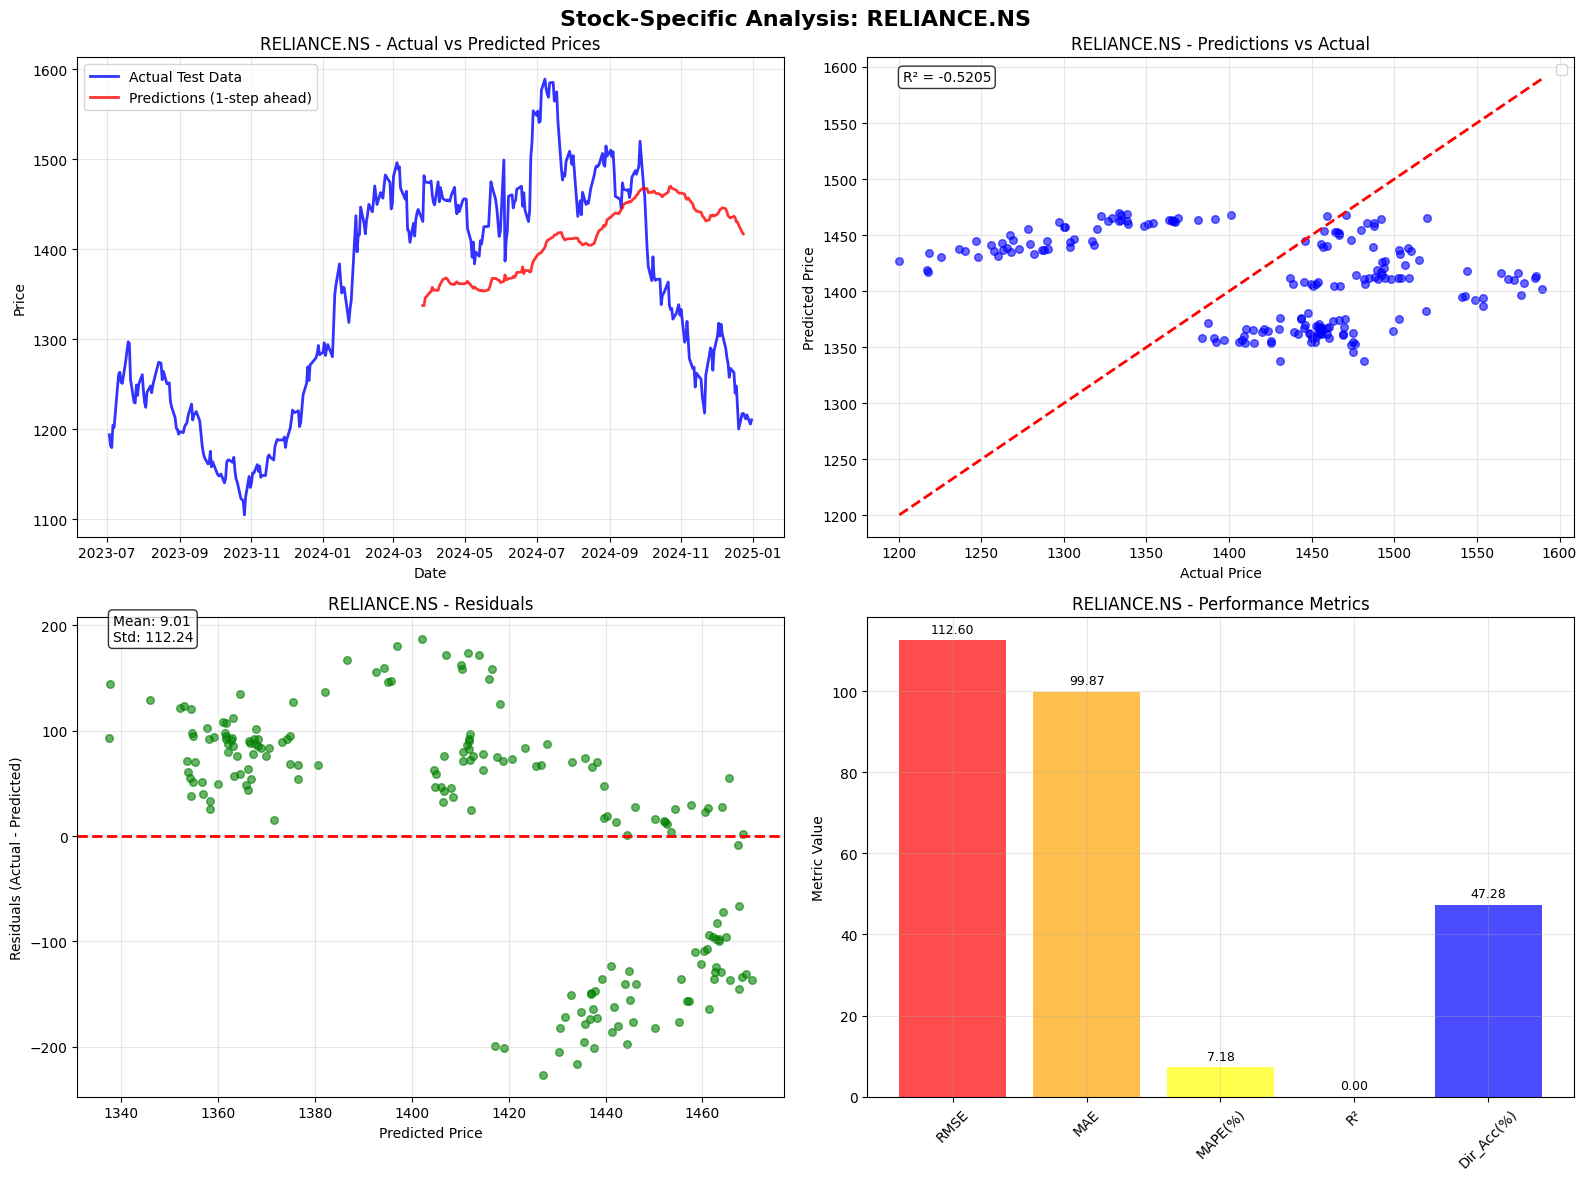

✅ RELIANCE.NS evaluation done | RMSE: 112.6048 | MAE: 99.8742 | MAPE: 7.18% | R²: -0.5205 | DirAcc: 47.28%

✅ Evaluation completed


In [29]:
# 8. Evaluation & Visualizations

def evaluate_stock_model(ticker: str, model: nn.Module, datasets: Dict, device: str):
    test_loader = datasets['test_loader']
    scaler = datasets['target_scaler'] if 'target_scaler' in datasets else datasets['scaler']

    model.eval()
    preds, tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            if out.dim() == 3 and out.shape[-1] == 1:
                out = out.squeeze(-1)
            if yb.dim() == 3 and yb.shape[-1] == 1:
                yb = yb.squeeze(-1)
            # Use first-step horizon for alignment
            preds.extend(out[:, 0].cpu().numpy().flatten())
            tgts.extend(yb[:, 0].cpu().numpy().flatten())

    preds = np.array(preds)
    tgts = np.array(tgts)
    n = min(len(preds), len(tgts))
    preds, tgts = preds[:n], tgts[:n]

    pred_inv = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
    tgt_inv = scaler.inverse_transform(tgts.reshape(-1,1)).flatten()

    mse = mean_squared_error(tgt_inv, pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(tgt_inv, pred_inv)
    mape = np.mean(np.abs((tgt_inv - pred_inv) / (tgt_inv + 1e-8))) * 100
    r2 = r2_score(tgt_inv, pred_inv)

    if len(tgt_inv) > 1:
        dir_acc = np.mean(np.sign(np.diff(tgt_inv)) == np.sign(np.diff(pred_inv))) * 100
    else:
        dir_acc = np.nan

    return {
        'predictions': pred_inv,
        'targets': tgt_inv,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2, 'Directional_Accuracy': dir_acc}
    }


def plot_stock_results(ticker: str, results: Dict, stock_splits: Dict):
    import re
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Stock-Specific Analysis: {ticker}', fontsize=16, fontweight='bold')

    splits = stock_splits[ticker]
    test_data = splits['test']

    preds = results['predictions']
    tgts = results['targets']

    # 1) Time series
    ax1 = axes[0,0]
    ax1.plot(test_data['Date'], test_data['Close'], label='Actual Test Data', color='blue', linewidth=2, alpha=0.8)
    if len(preds) > 0 and len(tgts) > 0:
        start_idx = CONFIG['sequence_length']
        end_idx = min(start_idx + len(preds), len(test_data))
        pred_dates = test_data['Date'].iloc[start_idx:end_idx]
        ax1.plot(pred_dates, preds[:len(pred_dates)], label='Predictions (1-step ahead)', color='red', linewidth=2, alpha=0.8)
    ax1.set_title(f'{ticker} - Actual vs Predicted Prices')
    ax1.set_xlabel('Date'); ax1.set_ylabel('Price'); ax1.legend(); ax1.grid(True, alpha=0.3)

    # 2) Scatter
    ax2 = axes[0,1]
    if len(preds) > 0 and len(tgts) > 0:
        ax2.scatter(tgts, preds, alpha=0.6, color='blue', s=30)
        mn, mx = min(tgts.min(), preds.min()), max(tgts.max(), preds.max())
        ax2.plot([mn, mx], [mn, mx], 'r--', lw=2)
        ax2.text(0.05, 0.95, f"R² = {results['metrics']['R2']:.4f}", transform=ax2.transAxes,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax2.set_xlabel('Actual Price'); ax2.set_ylabel('Predicted Price'); ax2.set_title(f'{ticker} - Predictions vs Actual'); ax2.legend()
    else:
        ax2.text(0.5,0.5,'No prediction data', ha='center', va='center', transform=ax2.transAxes)
    ax2.grid(True, alpha=0.3)

    # 3) Residuals
    ax3 = axes[1,0]
    if len(preds) > 0 and len(tgts) > 0:
        res = tgts - preds
        ax3.scatter(preds, res, alpha=0.6, color='green', s=30)
        ax3.axhline(0, color='red', linestyle='--', linewidth=2)
        ax3.text(0.05, 0.95, f"Mean: {np.mean(res):.2f}\nStd: {np.std(res):.2f}", transform=ax3.transAxes,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax3.set_xlabel('Predicted Price'); ax3.set_ylabel('Residuals (Actual - Predicted)'); ax3.set_title(f'{ticker} - Residuals')
    else:
        ax3.text(0.5,0.5,'No residuals', ha='center', va='center', transform=ax3.transAxes)
    ax3.grid(True, alpha=0.3)

    # 4) Metrics bar
    ax4 = axes[1,1]
    m = results['metrics']
    names = ['RMSE','MAE','MAPE(%)','R²','Dir_Acc(%)']
    vals = [m['RMSE'], m['MAE'], m['MAPE'], max(0, m['R2'])*100, m['Directional_Accuracy'] if not np.isnan(m['Directional_Accuracy']) else 0]
    bars = ax4.bar(names, vals, color=['red','orange','yellow','green','blue'], alpha=0.7)
    ax4.set_title(f'{ticker} - Performance Metrics'); ax4.set_ylabel('Metric Value'); ax4.tick_params(axis='x', rotation=45)
    for b, v in zip(bars, vals):
        ax4.text(b.get_x()+b.get_width()/2., b.get_height()+max(vals)*0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    safe_ticker = re.sub(r'[^A-Za-z0-9_-]+', '_', ticker)
    plt.savefig(f"{CONFIG['results_dir']}/{safe_ticker}_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    return fig


if 'stock_models' in locals() and 'stock_datasets' in locals():
    stock_results = {}
    all_metrics = {}
    for t, model in stock_models.items():
        print(f"\n📊 Evaluating {t}...")
        try:
            res = evaluate_stock_model(t, model, stock_datasets[t], CONFIG['device'])
            stock_results[t] = res
            all_metrics[t] = res['metrics']
            plot_stock_results(t, res, stock_splits)
            print(f"✅ {t} evaluation done | RMSE: {res['metrics']['RMSE']:.4f} | MAE: {res['metrics']['MAE']:.4f} | MAPE: {res['metrics']['MAPE']:.2f}% | R²: {res['metrics']['R2']:.4f} | DirAcc: {res['metrics']['Directional_Accuracy']:.2f}%")
        except Exception as e:
            print(f"❌ Error evaluating {t}: {e}")
            continue
    print("\n✅ Evaluation completed")
else:
    print("❌ Missing models/datasets for evaluation")


In [30]:
# 9. Results Summary

def create_summary(stock_results: Dict, all_metrics: Dict):
    print("🎯 LSTM STOCK-SPECIFIC RESULTS SUMMARY")
    print("="*80)
    print(f"Total stocks evaluated: {len(stock_results)}")
    print(f"Sequence length: {CONFIG['sequence_length']} | Horizon: {CONFIG['forecast_horizon']}")

    # Table
    print(f"{'Stock':<15} {'RMSE':<10} {'MAE':<10} {'MAPE(%)':<10} {'R²':<10} {'DirAcc(%)':<12}")
    print("-"*80)
    for t, m in all_metrics.items():
        print(f"{t:<15} {m['RMSE']:<10.4f} {m['MAE']:<10.4f} {m['MAPE']:<10.2f} {m['R2']:<10.4f} {m['Directional_Accuracy']:<12.2f}")

    rmse_vals = [m['RMSE'] for m in all_metrics.values()]
    mae_vals = [m['MAE'] for m in all_metrics.values()]
    mape_vals = [m['MAPE'] for m in all_metrics.values()]
    r2_vals = [m['R2'] for m in all_metrics.values()]
    dir_vals = [m['Directional_Accuracy'] for m in all_metrics.values() if not np.isnan(m['Directional_Accuracy'])]

    summary = {
        'total_stocks': len(stock_results),
        'sequence_length': CONFIG['sequence_length'],
        'prediction_horizon': CONFIG['forecast_horizon'],
        'individual_metrics': all_metrics,
        'aggregate_stats': {
            'mean_rmse': float(np.mean(rmse_vals)) if rmse_vals else None,
            'mean_mae': float(np.mean(mae_vals)) if mae_vals else None,
            'mean_mape': float(np.mean(mape_vals)) if mape_vals else None,
            'mean_r2': float(np.mean(r2_vals)) if r2_vals else None,
            'mean_dir_acc': float(np.mean(dir_vals)) if dir_vals else None,
        }
    }
    with open(f"{CONFIG['results_dir']}/project_summary.json", 'w') as f:
        json.dump(
            summary,
            f,
            indent=2,
            default=lambda o: float(o) if isinstance(o, (np.floating, np.integer)) else (o.tolist() if isinstance(o, np.ndarray) else str(o))
        )
    print(f"💾 Saved summary to {CONFIG['results_dir']}/project_summary.json")
    return summary

if 'stock_results' in locals() and 'all_metrics' in locals():
    results_summary = create_summary(stock_results, all_metrics)
    print("✅ Analysis complete")
else:
    print("❌ No results available for summary")


🎯 LSTM STOCK-SPECIFIC RESULTS SUMMARY
Total stocks evaluated: 1
Sequence length: 180 | Horizon: 5
Stock           RMSE       MAE        MAPE(%)    R²         DirAcc(%)   
--------------------------------------------------------------------------------
RELIANCE.NS     112.6048   99.8742    7.18       -0.5205    47.28       
💾 Saved summary to results/project_summary.json
✅ Analysis complete
